In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
import gymnasium as gym
import ale_py
import AutoROM

In [3]:
import gymnasium as gym

env = gym.make("BeamRiderNoFrameskip-v4", render_mode="human")
obs, info = env.reset()
print("✅ Beam Rider environment loaded successfully!")
env.close()

✅ Beam Rider environment loaded successfully!


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super().__init__()
        c, h, w = obs_shape  # now c = 4
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1), nn.ReLU()
        )

        conv_out_size = self._get_conv_out(obs_shape)
        self.fc = nn.Sequential(nn.Linear(conv_out_size, 512), nn.ReLU())
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def _get_conv_out(self, shape):
        o = torch.zeros(1, *shape)
        o = self.conv(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        x = x / 255.0  # normalize pixel values
        conv_out = self.conv(x).view(x.size(0), -1)
        fc_out = self.fc(conv_out)
        return self.actor(fc_out), self.critic(fc_out)

In [5]:
class PPOAgent:
    def __init__(self, obs_shape, n_actions, lr=2.5e-4, gamma=0.99, clip_eps=0.1, k_epochs=4):
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.k_epochs = k_epochs

        self.policy = ActorCritic(obs_shape, n_actions)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # (1, 4, 84, 84)
        with torch.no_grad():
            logits, value = self.policy(state)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value.item()

    def compute_returns(self, rewards, dones, next_value):
        R = next_value
        returns = []
        for r, d in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - d)
            returns.insert(0, R)
        return torch.tensor(returns, dtype=torch.float32)

    def update(self, memory):
        states = torch.FloatTensor(np.array(memory["states"]))
        actions = torch.LongTensor(memory["actions"])
        old_log_probs = torch.stack(memory["log_probs"]).detach()
        returns = torch.FloatTensor(memory["returns"])

        for _ in range(self.k_epochs):
            logits, values = self.policy(states)
            dist = Categorical(torch.softmax(logits, dim=-1))
            log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            ratios = (log_probs - old_log_probs).exp()
            advantages = returns - values.squeeze().detach()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps) * advantages

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(values.squeeze(), returns)
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


In [ ]:
def preprocess(obs):
    import cv2
    obs_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs_resized = cv2.resize(obs_gray, (84, 84), interpolation=cv2.INTER_AREA)
    return obs_resized

In [ ]:
def train_beamrider(episodes=500, log_interval=10, save_path="beamrider_ppo.pth"):
    import os
    from datetime import datetime

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join("runs", f"beamrider_{run_id}")
    os.makedirs(log_dir, exist_ok=True)
    log_file_path = os.path.join(log_dir, "training_log.csv")

    # Initialize CSV log file
    if not os.path.exists(log_file_path):
        with open(log_file_path, "w") as f:
            f.write("episode,total_reward,avg_reward_10,best_reward\n")

    env = gym.make("BeamRiderNoFrameskip-v4", render_mode="human")
    obs, _ = env.reset()
    obs = preprocess(obs)
    state_shape = (4, 84, 84)  
    n_actions = env.action_space.n

    agent = PPOAgent(state_shape, n_actions)
    reward_history = []
    best_avg_reward = -float("inf")

    frame_stack = deque(maxlen=4)
    for _ in range(4):
        frame_stack.append(np.zeros((84, 84), dtype=np.uint8))

    for ep in range(episodes):
        obs, _ = env.reset()
        frame_stack.extend([preprocess(obs)] * 4)
        total_reward = 0
        done = False

        memory = {"states": [], "actions": [], "log_probs": [], "rewards": [], "dones": [], "returns": []}

        while not done:
            state = np.stack(frame_stack, axis=0)
            action, log_prob, value = agent.select_action(state)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            frame_stack.append(preprocess(obs))

            memory["states"].append(state)
            memory["actions"].append(action)
            memory["log_probs"].append(log_prob)
            memory["rewards"].append(reward)
            memory["dones"].append(done)
            total_reward += reward

        with torch.no_grad():
            state = np.stack(frame_stack, axis=0)
            _, next_value = agent.policy(torch.FloatTensor(state).unsqueeze(0))
            next_value = next_value.item()

        memory["returns"] = agent.compute_returns(memory["rewards"], memory["dones"], next_value)
        agent.update(memory)

        reward_history.append(total_reward)

        recent_rewards = reward_history[-10:] if len(reward_history) >= 10 else reward_history
        avg_r_10 = float(np.mean(recent_rewards))

        is_best = avg_r_10 > best_avg_reward
        if is_best:
            best_avg_reward = avg_r_10
            torch.save({
                "policy_state_dict": agent.policy.state_dict(),
                "optimizer_state_dict": agent.optimizer.state_dict(),
                "reward_history": reward_history,
                "episode": ep + 1,
                "best_avg_reward": best_avg_reward
            }, os.path.join(log_dir, "best_model.pth"))

        with open(log_file_path, "a") as f:
            f.write(f"{ep+1},{total_reward},{avg_r_10},{best_avg_reward}\n")

        print(f"Episode {ep+1}: Reward = {total_reward:.1f}, Avg10 = {avg_r_10:.2f}, BestAvg10 = {best_avg_reward:.2f}")

        if (ep + 1) % log_interval == 0:
            ckpt_path = os.path.join(log_dir, f"checkpoint_ep{ep+1}.pth")
            torch.save({
                "policy_state_dict": agent.policy.state_dict(),
                "optimizer_state_dict": agent.optimizer.state_dict(),
                "reward_history": reward_history,
                "episode": ep + 1,
                "best_avg_reward": best_avg_reward
            }, ckpt_path)
            print(f"Saved checkpoint to {ckpt_path}")

    env.close()
    plt.plot(reward_history)
    plt.title("PPO on BeamRider-v4")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

In [ ]:
train_beamrider(episodes=200)

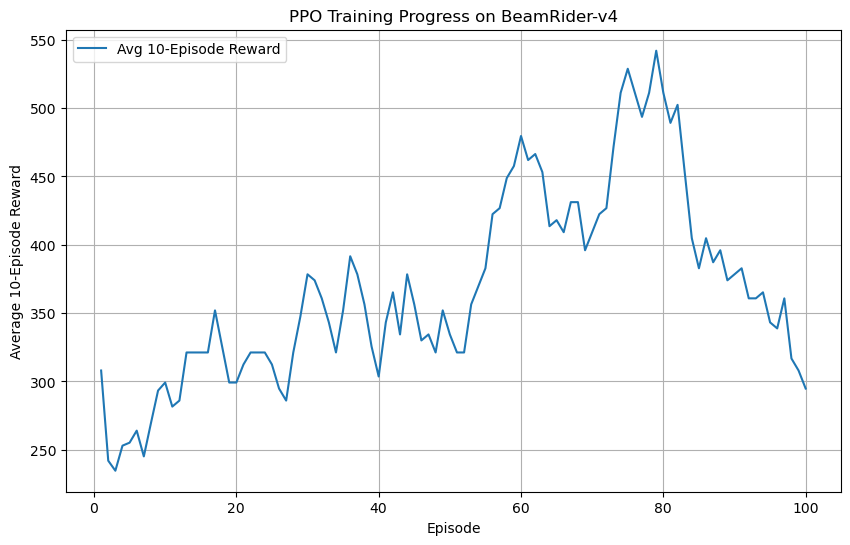

In [6]:
log_file_path = "runs/beamrider_20251119_140617/training_log copy.csv"
log_df = pd.read_csv(log_file_path)

plt.figure(figsize=(10, 6))
plt.plot(log_df["episode"], log_df["avg_reward_10"], label="Avg 10-Episode Reward")
plt.title("PPO Training Progress on BeamRider-v4")
plt.xlabel("Episode")
plt.ylabel("Average 10-Episode Reward")
plt.legend()
plt.grid(True)
plt.show()